<center>
<h1>
    Capitec stock prices modeling using regression methods
</h1>
<hr/>
</center>
<center>
    <p>
        <center>
        <author>Sifiso Rimana</author>
        <b>Investors @ Work</b>
        </center>
    </p>
    <date>November, 2024</date>
</center>

In [105]:
# load important packages
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt, dates as mdates
from sklearn.metrics import mean_squared_error as mse, root_mean_squared_error as rmse, r2_score

## Utility functions (reader may skim and skip)

In [136]:
def plot_prices(data, date_intervals, prices='close', month_interval=3, title="Capitec closing prices"):
    start, end = date_intervals
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    # create the chart
    plt.figure(figsize=(12,6))
    plt.plot(data.loc[start:end][[prices]])
    # locator and formatter
    locator = mdates.MonthLocator(interval=month_interval)
    formatter = mdates.DateFormatter('%Y-%m')
    # set locator and formatter
    ax = plt.gca()
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    # chart appearance
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel(f'{prices.title()} price')
    plt.xticks(rotation=45)
    plt.grid(True)
    # show chart
    plt.tight_layout()
    plt.show()

In [77]:
def plot_actual_vs_predicted(data, model, model_name, date_intervals, const=True month_interval=3, title="Capitec closing prices"):
    start, end = date_intervals
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
        
    true_values=data.loc[start:end][["close"]]
    predicted_values=model.predict(data.loc[start:end].drop(['close'], axis=1))
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(true_values, label='Actual Closing Prices', color='blue', linewidth=1)
    plt.plot(true_values.index, predicted_values, label=model_name, color='orangered', linewidth=1, linestyle='--',)
    
    locator = mdates.MonthLocator(interval=month_interval)
    formatter = mdates.DateFormatter('%Y-%m')
    # set locator and formatter
    ax = plt.gca()
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    # chart appearance
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Close price')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    # show chart
    plt.tight_layout()
    plt.show()

In [88]:
def get_metrics(model, X_train, X_test, y_train, y_test):
    train_rmse = rmse(y_train, model.predict(X_train))
    test_rmse = rmse(y_test, model.predict(X_test))
    test_r_squared = r2_score(y_test, model.predict(X_test))
    train_r_squared = r2_score(y_train, model.predict(X_train))

    metrics = {
        "RMSE": {
            "Train": round(train_rmse, 2),
            "Test": round(test_rmse, 2),
        },
        "R Squared": {
            "Train": round(train_r_squared, 5),
            "Test": round(test_r_squared, 5)
        }
    }
    return pd.DataFrame(metrics)

In [96]:
def shift_data(data):
    # Create a new column 'previous_close' that shifts the 'close' column by 1
    df=data.copy()
    df['previous_close'] = df['close'].shift(1)
    
    # Shift the other columns to match the data structure (if needed)
    df['previous_open'] = df['open'].shift(1)
    df['previous_high'] = df['high'].shift(1)
    df['previous_low'] = df['low'].shift(1)
    df['previous_volume'] = df['volume'].shift(1)
    
    # Drop the rows with NaN values that result from the shift (if necessary)
    df = df.dropna()
    df = df.drop(["high", "low", "volume"], axis=1)
    return df

## Acquiring data from Yahoo! Finance via ```yfinance```

We will use ```yfinance``` package to download Capitec stock prices data from 2016 January 1st to 2024 November 20th. For later use, we save the data file as ```capitec_2016-2024.csv```.

In [6]:
capitec_data = yf.download('CPI.JO', start='2016-01-01', end='2024-11-18')

[*********************100%***********************]  1 of 1 completed


In [7]:
# previe the data 
capitec_data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,CPI.JO,CPI.JO,CPI.JO,CPI.JO,CPI.JO,CPI.JO
Date,,,,,,
2016-01-01 00:00:00+00:00,46568.140625,53856.0,53856.0,53856.0,53856.0,0
2016-01-04 00:00:00+00:00,45827.976562,53000.0,54200.0,51854.0,52850.0,261226
2016-01-05 00:00:00+00:00,45309.171875,52400.0,54498.0,51846.0,52883.0,393167
2016-01-06 00:00:00+00:00,45023.832031,52070.0,53494.0,51800.0,51902.0,410499
2016-01-07 00:00:00+00:00,44963.300781,52000.0,52204.0,49500.0,51883.0,262435


We note that the columns need to be renamed for easily accessing them. We will also drop ```Adj Close``` column as we explained that we will not be using it.

In [9]:
data = capitec_data.copy()
data.columns = ["adj_close", "close", "high", "low", "open", "volume"]
data.drop('adj_close', axis=1, inplace=True)
data.head()

,close,high,low,open,volume
Date,,,,,
2016-01-01 00:00:00+00:00,53856.0,53856.0,53856.0,53856.0,0
2016-01-04 00:00:00+00:00,53000.0,54200.0,51854.0,52850.0,261226
2016-01-05 00:00:00+00:00,52400.0,54498.0,51846.0,52883.0,393167
2016-01-06 00:00:00+00:00,52070.0,53494.0,51800.0,51902.0,410499
2016-01-07 00:00:00+00:00,52000.0,52204.0,49500.0,51883.0,262435


In [10]:
# save to csv file
data.to_csv("capitec_2016-2024.csv")

## Exploratory Data Analysis

We now explore the data. We first divide the prices by $100$ and then start with summary statistics. The reason the prices are divided by $100$ is that Yahoo! Finance stores the stock prices in ZAR cents.

In [12]:
for col in ['close', 'open', 'high', 'low']:
    data[col] = data[col] / 100

In [14]:
round(data.describe(), 2)

,close,high,low,open,volume
count,2237.00,2237.00,2237.00,2237.00,2237.00
mean,1383.10,1402.25,1361.24,1380.60,271404.67
std,608.28,615.25,600.56,607.05,219649.34
min,437.00,449.52,429.49,438.50,0.00
25%,874.00,892.37,858.11,875.00,151671.00
50%,1335.38,1350.93,1313.98,1332.17,222316.00
75%,1831.28,1855.00,1805.06,1828.77,322608.00
max,3309.95,3355.39,3292.00,3326.75,4442021.00


We observe that there were times the ```volume``` was $0$, which would mean that there were no trades taking place on that day. This could be market holidays (or public holidays), or trading halt due to regulatories, or possible any other reason. We investigate such days where the ```volume``` was $0$.

In [17]:
zero_volume_days = data[data['volume'] == 0]
zero_volume_days.head()

,close,high,low,open,volume
Date,,,,,
2016-01-01 00:00:00+00:00,538.56,538.56,538.56,538.56,0
2016-03-21 00:00:00+00:00,576.53,576.53,576.53,576.53,0
2016-03-25 00:00:00+00:00,568.11,568.11,568.11,568.11,0
2016-03-28 00:00:00+00:00,568.11,568.11,568.11,568.11,0
2016-04-27 00:00:00+00:00,607.74,607.74,607.74,607.74,0


In [18]:
zero_volume_days.index.min()

Timestamp('2016-01-01 00:00:00+0000', tz='UTC')

In [19]:
zero_volume_days.index.max()

Timestamp('2017-12-26 00:00:00+0000', tz='UTC')

Zero volume dates happen between 2016 Jan 1st and 2017 Dec 26th, we curiously plot the closing price movements between these periods

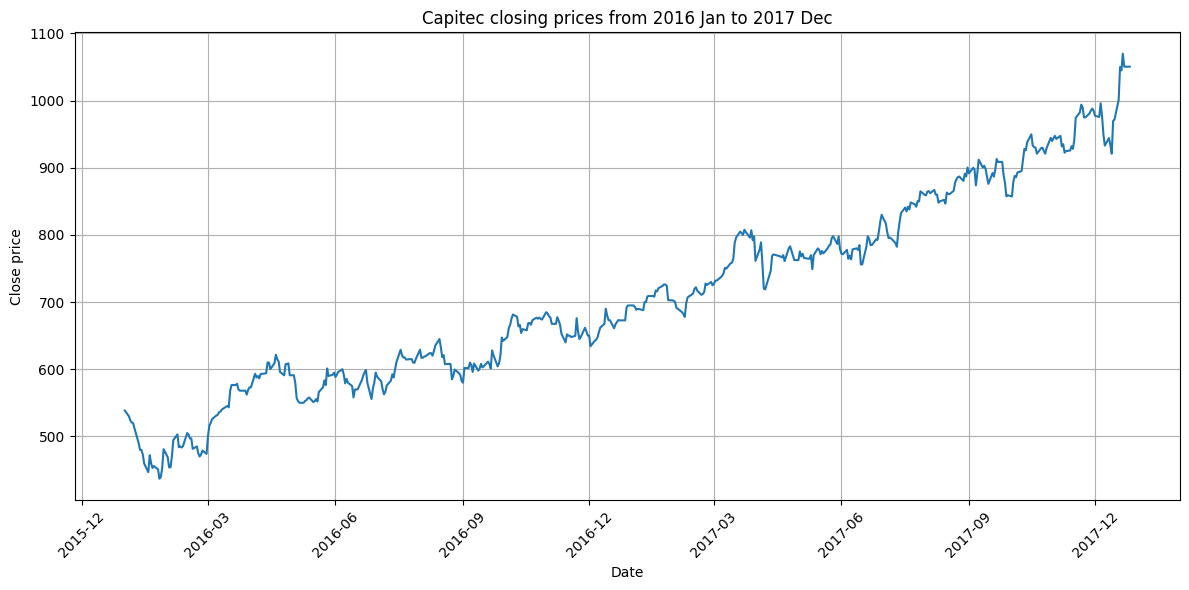

In [131]:
plot_prices(
    zero_volume_days_span, 
    (zero_volume_days.index.min(), zero_volume_days.index.max()),
    prices="close",
    title = "Capitec closing prices from 2016 Jan to 2017 Dec"
)

In [41]:
len(zero_volume_days)

19

In [42]:
len(zero_volume_days_span)

514

In [43]:
len(data)

2237

Since only about 19 days recorded there was actually no trades (or no volume), we can safely discard such days and consider only those were there were actual trades (non-zero volume).

In [44]:
data = data[data['volume'] != 0]

In [45]:
len(data)

2218

In [46]:
data[data['volume'] == 0]

,close,high,low,open,volume
Date,,,,,


Indeed, Capitec stock price has risen from $437$ to $3309$ between $2016$ and $204$

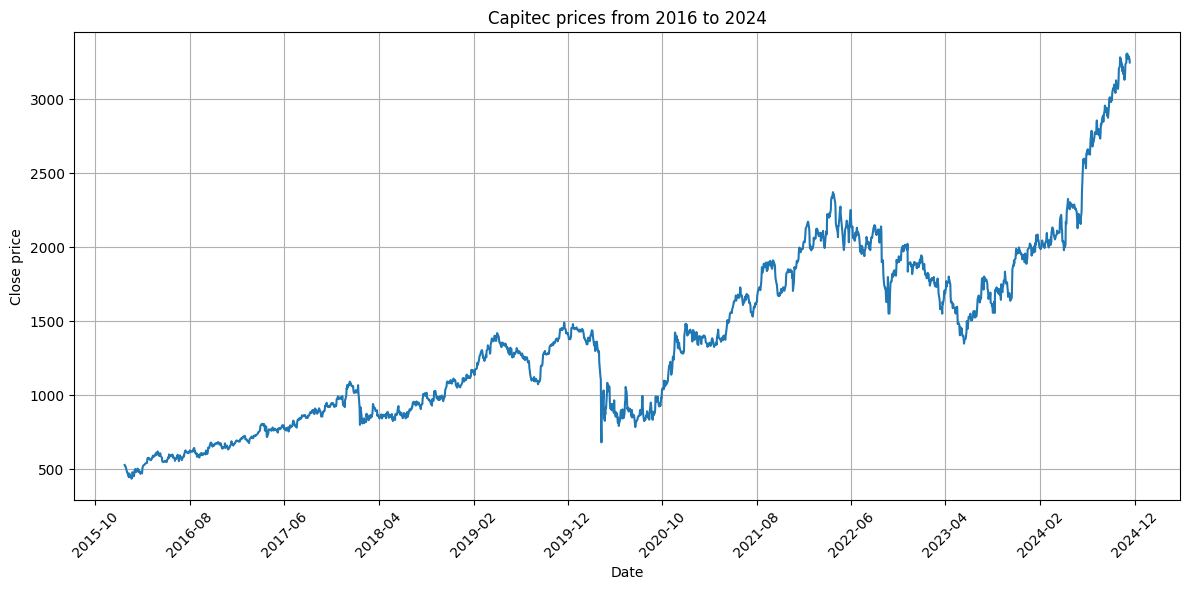

In [127]:
plot_prices(
    data,
    (data.index.min(), data.index.max()),
    title="Capitec prices from 2016 to 2024",
    month_interval=10
)

### August Boom

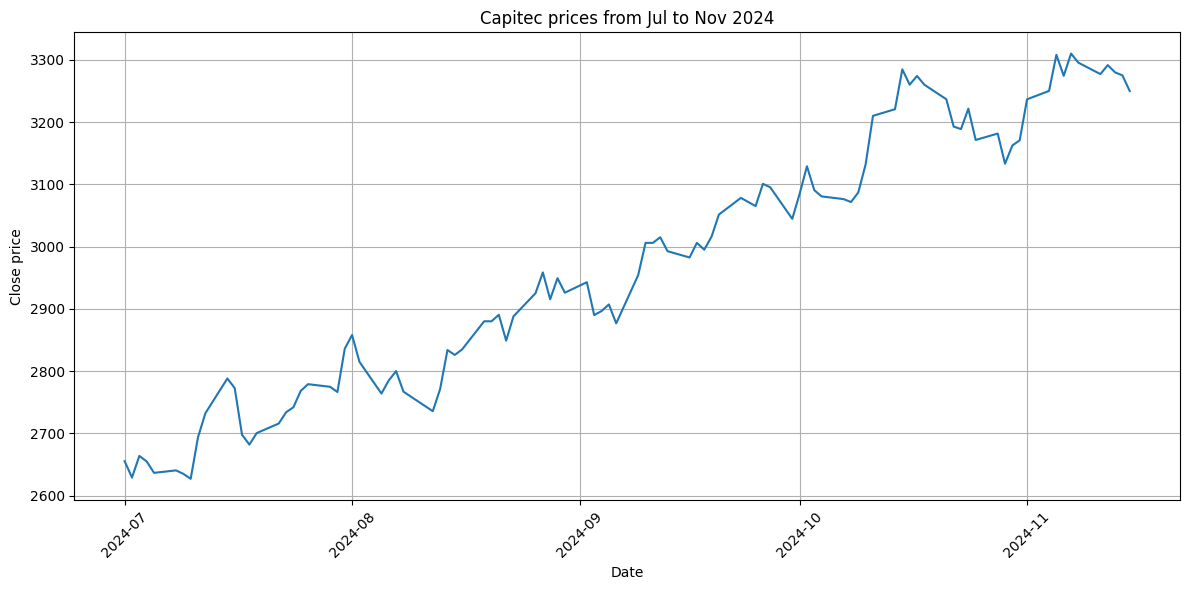

In [141]:
plot_prices(
    data,
    ('2024-07-1 00:00:00+0000', '2024-11-18 00:00:00+0000'),
    title="Capitec prices from Jul to Nov 2024",
    month_interval=1
)

### Volume distribution

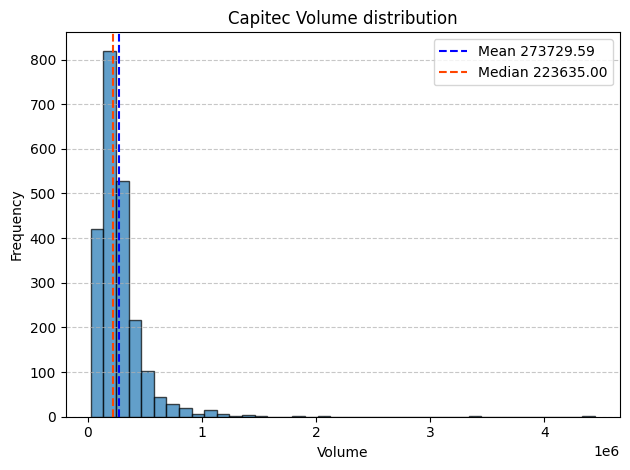

In [64]:
mean_volume = data.volume.mean()
median_volume = data.volume.median()
plt.hist(data['volume'], bins=40, edgecolor="black", alpha=0.7)
plt.axvline(mean_volume, color='blue', linestyle="dashed", linewidth=1.5, label=f"Mean {mean_volume:.2f}")
plt.axvline(median_volume, color='orangered', linestyle="dashed", linewidth=1.5, label=f"Median {median_volume:.2f}")
plt.title("Capitec Volume distribution")
plt.xlabel("Volume")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

## Part 1: Linear Regression (Ordinary Least Squares)

### Approach 1: Modeling today's close with today's data

In [81]:
data_X = data.drop('close', axis=1)
data_y = data[['close']]

# add a constant
data_X_with_const = sm.add_constant(data_X)

# split the data for training and testing (validation)
X_train, X_test, y_train, y_test = train_test_split(data_X_with_const, data_y, test_size=0.2, random_state=42)

# fit the data
ap1_ols = sm.OLS(y_train, X_train)
lm1_ap1 = ap1_ols.fit()

# print the results summary
lm1_ap1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  close   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 8.323e+05
Date:                Thu, 21 Nov 2024   Prob (F-statistic):               0.00
Time:                        07:10:31   Log-Likelihood:                -7188.3
No. Observations:                1774   AIC:                         1.439e+04
Df Residuals:                    1769   BIC:                         1.441e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2567      0.931     -1.350      0.177      -3.082       0.569
high           0.6876      0.018     37.554      0.000       0.652       0.724
low            0.6923      0.019     35.781      0.000       0.654       0.730
open          -0.3800      0.018    -21.593      0.000      -0.415      -0.346
volume      8.375e-06   1.81e-06      4.630      0.000    4.83e-06    1.19e-05
==============================================================================
Omnibus:                      271.457   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4010.258
Skew:                          -0.135   Prob(JB):                         0.00
Kurtosis:                      10.361   Cond. No.                     9.97e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.97e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

\begin{equation*}
Y = -1.2567 + 0.6876 X_1 + 0.6923 X_2 - 0.3800 X_3 + 0.00008375 X_4
\end{equation*}
where:

- $X_1$ is the highest prices (high)
- $X_2$ is lowest price (low)
- $X_3$ is the open price
- $X_4$ is the volume 

#### Approach 1: Training without a constant

In [82]:
# fit the data without the constant
ap1_ols = sm.OLS(y_train, X_train.drop('const', axis=1))
lm2_ap1 = ap1_ols.fit()

# print the results summary
lm2_ap1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  close   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          5.229e+06
Date:                Thu, 21 Nov 2024   Prob (F-statistic):                        0.00
Time:                        07:10:39   Log-Likelihood:                         -7189.2
No. Observations:                1774   AIC:                                  1.439e+04
Df Residuals:                    1770   BIC:                                  1.441e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
high           0.6898      0.018     37.818      0.000       0.654       0.726
low            0.6887      0.019     35.923      0.000       0.651       0.726
open          -0.3794      0.018    -21.559      0.000      -0.414      -0.345
volume      7.321e-06   1.63e-06      4.485      0.000    4.12e-06    1.05e-05
==============================================================================
Omnibus:                      269.764   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4111.989
Skew:                          -0.069   Prob(JB):                         0.00
Kurtosis:                      10.457   Cond. No.                     2.52e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.52e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

\begin{equation*}
Y =  0.6898 X_1 + 0.6887 X_2 - 0.3794 X_3 + 0.00007321 X_4
\end{equation*}
where:

- $X_1$ is the highest prices (high)
- $X_2$ is lowest price (low)
- $X_3$ is the open price
- $X_4$ is the volume 

In [83]:
data.head()

,close,high,low,open,volume
Date,,,,,
2016-01-04 00:00:00+00:00,530.00,542.00,518.54,528.50,261226
2016-01-05 00:00:00+00:00,524.00,544.98,518.46,528.83,393167
2016-01-06 00:00:00+00:00,520.70,534.94,518.00,519.02,410499
2016-01-07 00:00:00+00:00,520.00,522.04,495.00,518.83,262435
2016-01-08 00:00:00+00:00,512.06,526.65,506.06,516.50,401212


In [80]:
training_cols

['open', 'high', 'low', 'volume']

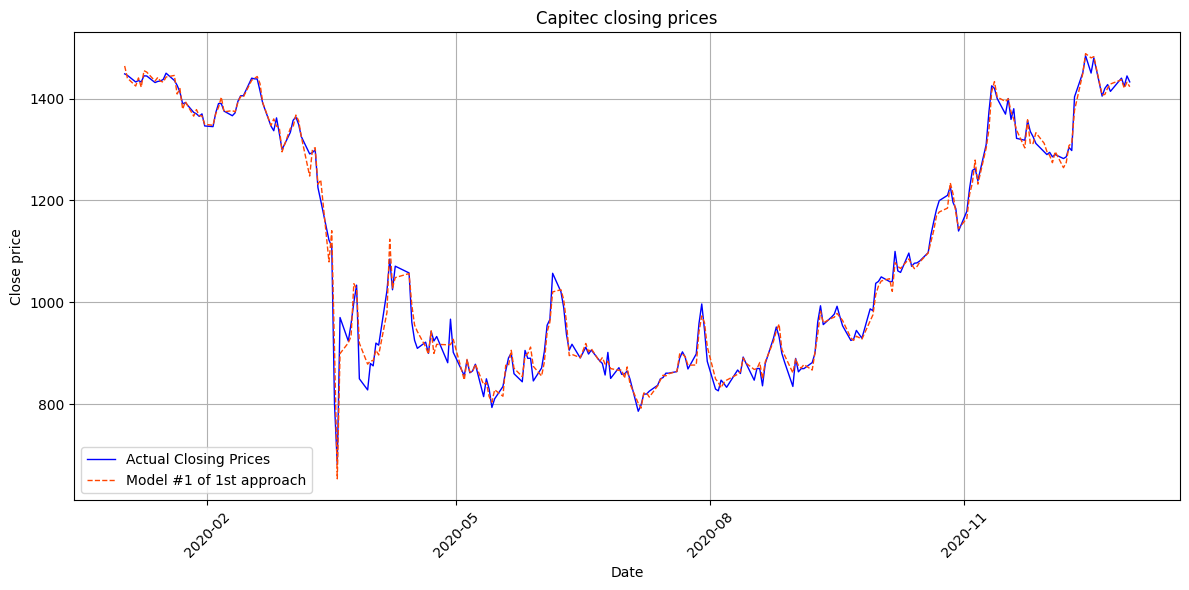

In [91]:
plot_actual_vs_predicted(
    data=sm.add_constant(data), 
    model=lm1_ap1, 
    model_name="Model #1 of 1st approach", 
    date_intervals=('2020-01-01 00:00:00+0000', '2020-12-31 00:00:00+0000')
)

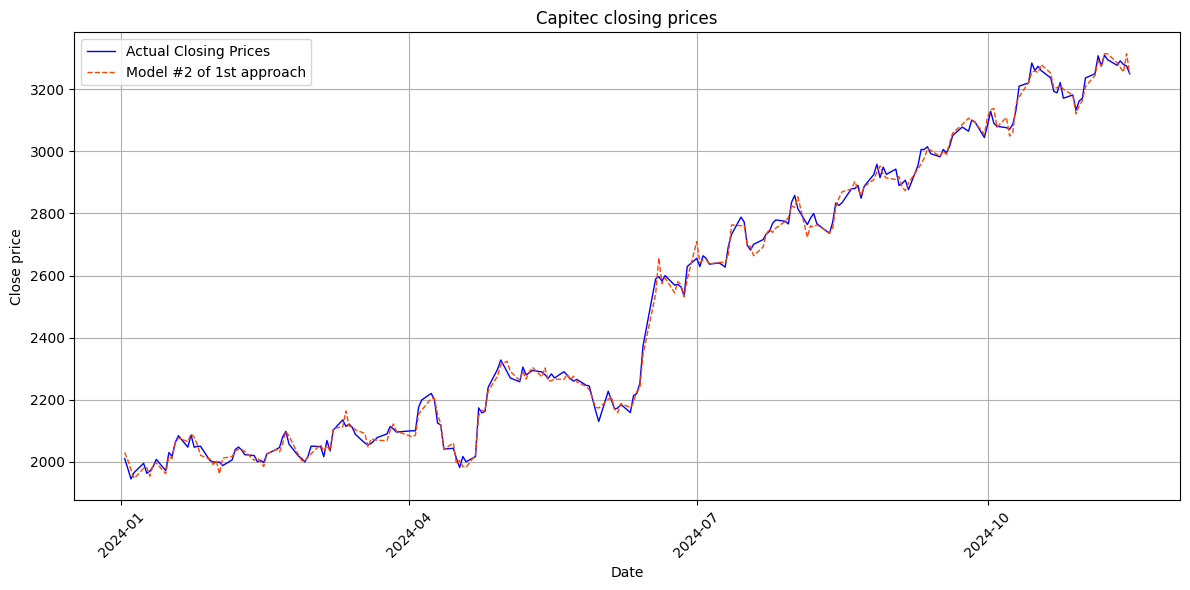

In [93]:
plot_actual_vs_predicted(
    data=data, 
    model=lm2_ap1, 
    model_name="Model #2 of 1st approach", 
    date_intervals=('2024-01-01 00:00:00+0000', '2024-11-20 00:00:00+0000')
)

In [89]:
get_metrics(
    model=lm1_ap1, 
    X_train=X_train, 
    X_test=X_test, 
    y_train=y_train, 
    y_test=y_test
)

,RMSE,R Squared
Train,13.92,0.99947
Test,13.41,0.99953


In [90]:
get_metrics(
    model=lm2_ap1, 
    X_train=X_train.drop('const', axis=1), 
    X_test=X_test.drop('const', axis=1), 
    y_train=y_train, 
    y_test=y_test
)

,RMSE,R Squared
Train,13.92,0.99947
Test,13.37,0.99954


### Approach 2: Modelling today's close using yesterday's data

In [97]:
shifted_data = shift_data(data)

In [98]:
shifted_data.head()

,close,open,previous_close,previous_open,previous_high,previous_low,previous_volume
Date,,,,,,,
2016-01-05 00:00:00+00:00,524.00,528.83,530.00,528.50,542.00,518.54,261226.0
2016-01-06 00:00:00+00:00,520.70,519.02,524.00,528.83,544.98,518.46,393167.0
2016-01-07 00:00:00+00:00,520.00,518.83,520.70,519.02,534.94,518.00,410499.0
2016-01-08 00:00:00+00:00,512.06,516.50,520.00,518.83,522.04,495.00,262435.0
2016-01-11 00:00:00+00:00,490.00,499.00,512.06,516.50,526.65,506.06,401212.0


In [100]:
X_train, X_test, y_train, y_test = train_test_split(
    shifted_data.drop(['close'], axis=1), shifted_data['close'], test_size=0.2, random_state=42)

In [102]:
lm1_ap2 = sm.OLS(y_train, sm.add_constant(X_train)).fit()
lm1_ap2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  close   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.383e+05
Date:                Thu, 21 Nov 2024   Prob (F-statistic):               0.00
Time:                        07:40:45   Log-Likelihood:                -8424.1
No. Observations:                1773   AIC:                         1.686e+04
Df Residuals:                    1766   BIC:                         1.690e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.4828      1.880      0.257      0.797      -3.204       4.169
open                0.3722      0.043      8.705      0.000       0.288       0.456
previous_close      0.7683      0.060     12.720      0.000       0.650       0.887
previous_open      -0.0573      0.039     -1.461      0.144      -0.134       0.020
previous_high      -0.0399      0.049     -0.806      0.420      -0.137       0.057
previous_low       -0.0428      0.051     -0.842      0.400      -0.142       0.057
previous_volume -2.564e-07   3.71e-06     -0.069      0.945   -7.54e-06    7.02e-06
==============================================================================
Omnibus:                      444.016   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26864.510
Skew:                          -0.124   Prob(JB):                         0.00
Kurtosis:                      22.068   Cond. No.                     9.93e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.93e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [103]:
insignificant_cols = ['previous_open', 'previous_high', 'previous_low', 'previous_volume']

In [104]:
lm2_ap2 = sm.OLS(y_train, X_train.drop(insignificant_cols, axis=1)).fit()
lm2_ap2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  close   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.568e+06
Date:                Thu, 21 Nov 2024   Prob (F-statistic):                        0.00
Time:                        07:45:06   Log-Likelihood:                         -8432.9
No. Observations:                1773   AIC:                                  1.687e+04
Df Residuals:                    1771   BIC:                                  1.688e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
open               0.3474      0.042      8.186      0.000       0.264       0.431
previous_close     0.6536      0.042     15.413      0.000       0.570       0.737
==============================================================================
Omnibus:                      440.517   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26110.311
Skew:                          -0.111   Prob(JB):                         0.00
Kurtosis:                      21.799   Cond. No.                         192.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$$
Y = 0.3474X_1 + 0.6536X_2
$$
or 
\begin{align*}
\text{Today's Close} &= 0.3474\times \text{Today's Open} \\
                    &+ 0.6536\times \text{Yesterday's Close}
\end{align*}

In [108]:
get_metrics(
    model=lm1_ap2, 
    X_train=sm.add_constant(X_train), 
    X_test=sm.add_constant(X_test), 
    y_train=y_train, 
    y_test=y_test
)

,RMSE,R Squared
Train,28.00,0.99788
Test,25.23,0.99826


In [109]:
get_metrics(
    model=lm2_ap2, 
    X_train=X_train.drop(insignificant_cols, axis=1), 
    X_test=X_test.drop(insignificant_cols, axis=1), 
    y_train=y_train, 
    y_test=y_test
)

,RMSE,R Squared
Train,28.14,0.99785
Test,25.22,0.99826


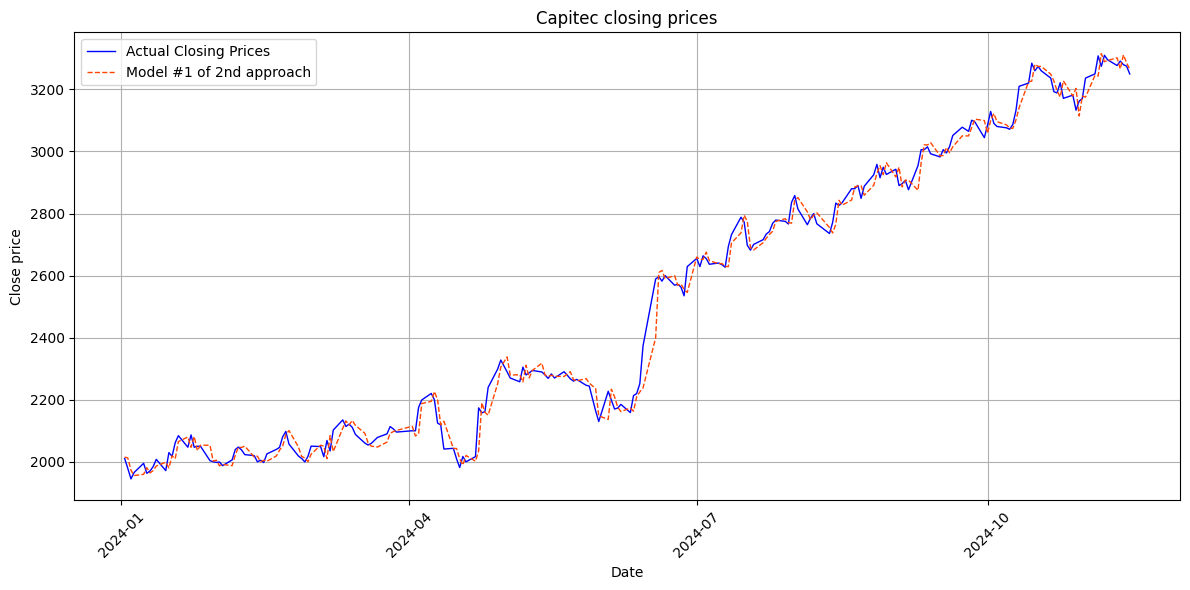

In [114]:
plot_actual_vs_predicted(
    data=sm.add_constant(shifted_data), 
    model=lm1_ap2, 
    model_name="Model #1 of 2nd approach", 
    date_intervals=('2024-01-01 00:00:00+0000', '2024-11-20 00:00:00+0000')
)

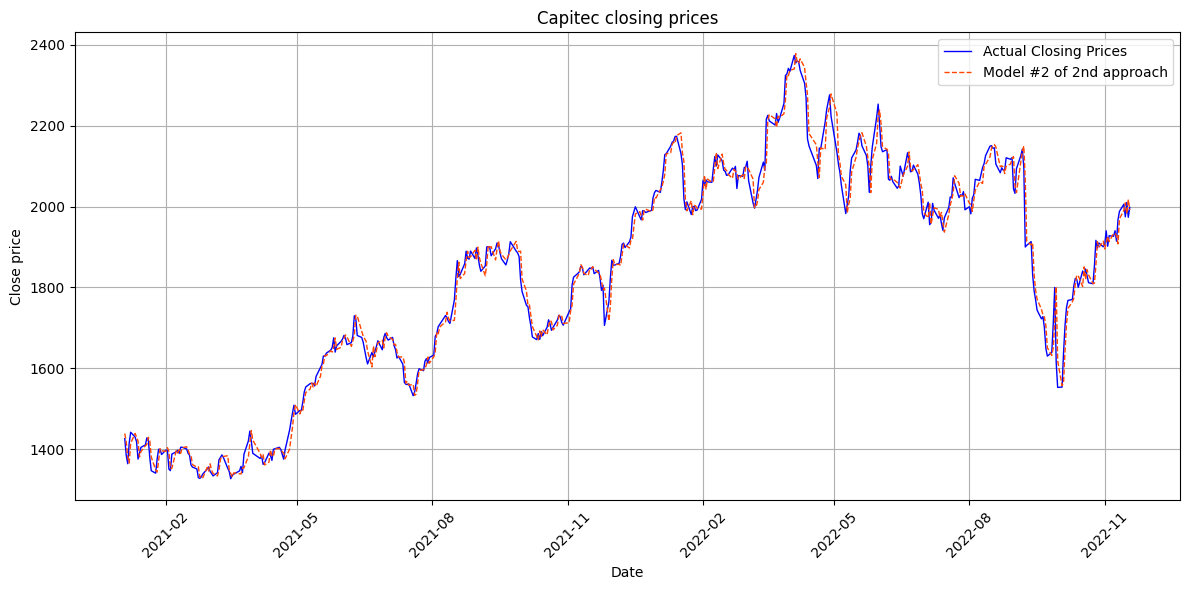

In [126]:
plot_actual_vs_predicted(
    data=shifted_data.drop(insignificant_cols, axis=1), 
    model=lm2_ap2, 
    model_name="Model #2 of 2nd approach", 
    date_intervals=('2021-01-01 00:00:00+0000', '2022-11-20 00:00:00+0000')
)

## Part 2: Random Forest Regressor

In [106]:
rfr_50_2=RandomForestRegressor(n_estimators = 50, max_depth=5, random_state=42)
rfr_150_2=RandomForestRegressor(n_estimators = 150, max_depth=5, random_state=42)
rfr_100_2=RandomForestRegressor(n_estimators = 100, max_depth=5, random_state=42)
rfr_50_10_2=RandomForestRegressor(n_estimators = 50, max_depth=10, random_state=42)

In [107]:
rfr_50_2.fit(X_train, y_train)
rfr_150_2.fit(X_train, y_train)
rfr_100_2.fit(X_train, y_train)
rfr_50_10_2.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=50, random_state=42)

In [118]:
get_metrics(
    model=rfr_50_2, 
    X_train=X_train, 
    X_test=X_test, 
    y_train=y_train, 
    y_test=y_test
)

,RMSE,R Squared
Train,25.99,0.99817
Test,29.07,0.99769


In [119]:
get_metrics(
    model=rfr_150_2, 
    X_train=X_train, 
    X_test=X_test, 
    y_train=y_train, 
    y_test=y_test
)

,RMSE,R Squared
Train,25.79,0.99820
Test,28.94,0.99772


In [120]:
get_metrics(
    model=rfr_100_2, 
    X_train=X_train, 
    X_test=X_test, 
    y_train=y_train, 
    y_test=y_test
)

,RMSE,R Squared
Train,25.79,0.99820
Test,28.90,0.99772


In [121]:
get_metrics(
    model=rfr_50_10_2, 
    X_train=X_train, 
    X_test=X_test, 
    y_train=y_train, 
    y_test=y_test
)

,RMSE,R Squared
Train,14.14,0.99946
Test,29.07,0.99769


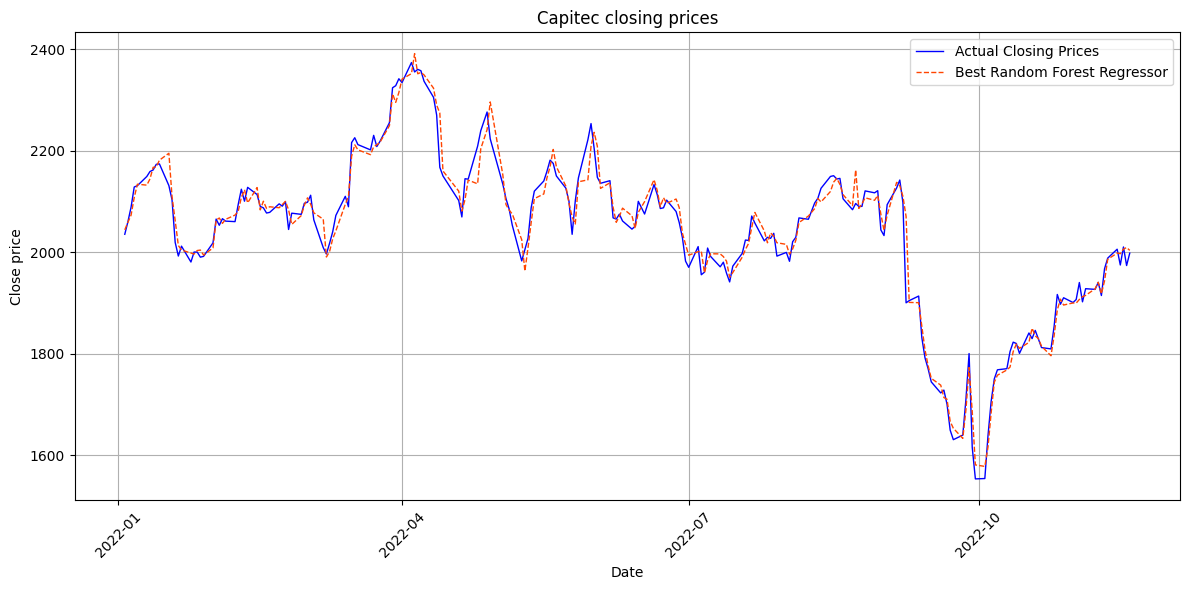

In [124]:
plot_actual_vs_predicted(
    data=shifted_data, 
    model=rfr_50_10_2, 
    model_name="Best Random Forest Regressor", 
    date_intervals=('2022-01-01 00:00:00+0000', '2022-11-20 00:00:00+0000')
)